In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

# project-specific custom functions
## export the path to custom modules
sys.path.append("../functions")
## import functions
from data_loading import load_data, get_label_name_from_filename

RSEED = 42
sns.set_theme(style="white", palette=None)

2024-05-22 20:15:54.064013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 20:15:55.141693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dir_data_base__relative = "../data/dataset_split_categories/"  # the relative directory path to all data files
dir_data_train = dir_data_base__relative+"train"
dir_data_val = dir_data_base__relative+"validation"
dir_data_test = dir_data_base__relative+"test"

In [3]:
IMG_SIZE_height, IMG_SIZE_width = 224, 224
BATCH_SIZE = 32

def get_dataset(data_dir, shuffle_flag):
    return tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(IMG_SIZE_height, IMG_SIZE_width),
    batch_size=BATCH_SIZE,
    shuffle=shuffle_flag,
    seed=RSEED,
    pad_to_aspect_ratio=True
)

dataset_train = get_dataset(data_dir=dir_data_train, shuffle_flag=True)
dataset_validation = get_dataset(data_dir=dir_data_val, shuffle_flag=False)
dataset_test = get_dataset(data_dir=dir_data_test, shuffle_flag=False)

Found 12955 files belonging to 8 classes.


2024-05-22 20:15:58.555553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 20:15:58.593558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 20:15:58.593646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 20:15:58.597862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 20:15:58.597987: I external/local_xla/xla/stream_executor

Found 1647 files belonging to 8 classes.
Found 1886 files belonging to 8 classes.


In [4]:
y_true_train = []
for _, lbl in dataset_train:
    y_true_train.extend(lbl.numpy())
y_true_train = np.array(y_true_train)

class_sums = y_true_train.sum(axis=0)
total_sum = y_true_train.sum(axis=(0, 1))
inv_class_ratios = 1 / (class_sums / total_sum)
inv_class_ratios = inv_class_ratios / np.sum(inv_class_ratios)

class_weight_dict = {k:v for (k,v) in zip(range(8), inv_class_ratios)}

2024-05-22 20:16:05.024913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
prebuilt_model = tf.keras.applications.ConvNeXtXLarge(include_top=False, pooling="max")
prebuilt_model.trainable = False

data_aug_layer = tf.keras.Sequential()
data_aug_layer.add(tf.keras.layers.RandomRotation(factor=0.1))
data_aug_layer.add(tf.keras.layers.RandomFlip(mode="horizontal"))
data_aug_layer.add(tf.keras.layers.RandomContrast(factor=0.4))
data_aug_layer.add(tf.keras.layers.RandomBrightness (factor=0.3))

model = tf.keras.Sequential()

model.add(data_aug_layer)
model.add(prebuilt_model)
model.add(tf.keras.layers.Dense(64, name="Dense1", activation="relu"))
model.add(tf.keras.layers.Dropout(0.3, name="Dropout1"))
model.add(tf.keras.layers.Dense(64, name="Dense2", activation="relu"))
model.add(tf.keras.layers.Dropout(0.3, name="Dropout2"))
model.add(tf.keras.layers.Dense(64, name="Dense3", activation="relu"))
model.add(tf.keras.layers.Dropout(0.3, name="Dropout3"))
model.add(tf.keras.layers.Dense(8, name="Final_output", activation="softmax"))

In [6]:
'''

for batch, labels in dataset_train:
    x = batch
    y = labels
    break

img = batch[7]
img = img[tf.newaxis, ...]
img_list = [img]
for _ in range(5+1):
    img_list.append(data_aug_layer(img))

label_list = ["original photo"] + 5*["modified photo"]
#
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, im, lab in zip(axes.flatten(), img_list, label_list):
    ax.imshow(im[0]/255.0)
    ax.set_axis_off()
    ax.set_title(lab)
'''


'\n\nfor batch, labels in dataset_train:\n    x = batch\n    y = labels\n    break\n\nimg = batch[7]\nimg = img[tf.newaxis, ...]\nimg_list = [img]\nfor _ in range(5+1):\n    img_list.append(data_aug_layer(img))\n\nlabel_list = ["original photo"] + 5*["modified photo"]\n#\nfig, axes = plt.subplots(2, 3, figsize=(15, 10))\nfor ax, im, lab in zip(axes.flatten(), img_list, label_list):\n    ax.imshow(im[0]/255.0)\n    ax.set_axis_off()\n    ax.set_title(lab)\n'

In [7]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [8]:
checkpoint_path = "../models/snapshots/cp_{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

n_batches = len(dataset_train)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=3*n_batches,
                                                 verbose=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=6,
                                               verbose=1,
                                               start_from_epoch=5,
                                               restore_best_weights=True)

In [9]:
history = model.fit(
    dataset_train,
    validation_data=dataset_validation,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[cp_callback, es_callback],
    validation_freq=3,
    epochs=24)

Epoch 1/24


2024-05-22 20:16:34.890379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716401795.554833    7207 service.cc:145] XLA service 0x7f9d5f5f1c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716401795.554916    7207 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
I0000 00:00:1716401796.310748    7207 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


405/405 ━━━━━━━━━━━━━━━━━━━━ 1534s 4s/step - accuracy: 0.2784 - loss: 0.2117
Epoch 2/24


/home/am/neuefische/Project__Wildlife_Images/.venv/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


405/405 ━━━━━━━━━━━━━━━━━━━━ 1497s 4s/step - accuracy: 0.4125 - loss: 0.1664
Epoch 3/24
404/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.4481 - loss: 0.1574
Epoch 3: saving model to ../models/snapshots/cp_0003.weights.h5
405/405 ━━━━━━━━━━━━━━━━━━━━ 1707s 4s/step - accuracy: 0.4481 - loss: 0.1574 - val_accuracy: 0.4772 - val_loss: 1.4860
Epoch 4/24
405/405 ━━━━━━━━━━━━━━━━━━━━ 1570s 4s/step - accuracy: 0.4562 - loss: 0.1529
Epoch 5/24
405/405 ━━━━━━━━━━━━━━━━━━━━ 1664s 4s/step - accuracy: 0.4597 - loss: 0.1516
Epoch 6/24
404/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.4722 - loss: 0.1506
Epoch 6: saving model to ../models/snapshots/cp_0006.weights.h5
405/405 ━━━━━━━━━━━━━━━━━━━━ 1792s 4s/step - accuracy: 0.4722 - loss: 0.1506 - val_accuracy: 0.5094 - val_loss: 1.4185
Epoch 7/24
405/405 ━━━━━━━━━━━━━━━━━━━━ 1485s 4s/step - accuracy: 0.4742 - loss: 0.1515
Epoch 8/24
405/405 ━━━━━━━━━━━━━━━━━━━━ 1484s 4s/step - accuracy: 0.4763 - loss: 0.1475
Epoch 9/24
404/405 ━━━━━━━━━━━━━━━━

2024-05-23 00:16:22.159529: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


405/405 ━━━━━━━━━━━━━━━━━━━━ 1484s 4s/step - accuracy: 0.4927 - loss: 0.1468
Epoch 11/24


2024-05-23 00:41:05.718983: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


405/405 ━━━━━━━━━━━━━━━━━━━━ 1485s 4s/step - accuracy: 0.4890 - loss: 0.1437
Epoch 12/24


2024-05-23 01:05:50.576675: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


404/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.4899 - loss: 0.1443
Epoch 12: saving model to ../models/snapshots/cp_0012.weights.h5
405/405 ━━━━━━━━━━━━━━━━━━━━ 1675s 4s/step - accuracy: 0.4899 - loss: 0.1443 - val_accuracy: 0.4930 - val_loss: 1.3228
Epoch 13/24


2024-05-23 01:33:45.564912: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


405/405 ━━━━━━━━━━━━━━━━━━━━ 1484s 4s/step - accuracy: 0.4995 - loss: 0.1414
Epoch 14/24


2024-05-23 01:58:29.760560: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


405/405 ━━━━━━━━━━━━━━━━━━━━ 1486s 4s/step - accuracy: 0.4997 - loss: 0.1412
Epoch 15/24


2024-05-23 02:23:15.862104: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


404/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.4978 - loss: 0.1416
Epoch 15: saving model to ../models/snapshots/cp_0015.weights.h5
405/405 ━━━━━━━━━━━━━━━━━━━━ 1675s 4s/step - accuracy: 0.4978 - loss: 0.1416 - val_accuracy: 0.5003 - val_loss: 1.2948
Epoch 16/24


2024-05-23 02:51:11.054780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


405/405 ━━━━━━━━━━━━━━━━━━━━ 1486s 4s/step - accuracy: 0.5060 - loss: 0.1410
Epoch 17/24


2024-05-23 03:15:57.322135: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


405/405 ━━━━━━━━━━━━━━━━━━━━ 1484s 4s/step - accuracy: 0.4988 - loss: 0.1421
Epoch 18/24


2024-05-23 03:40:41.504769: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


404/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.5128 - loss: 0.1403
Epoch 18: saving model to ../models/snapshots/cp_0018.weights.h5
405/405 ━━━━━━━━━━━━━━━━━━━━ 1678s 4s/step - accuracy: 0.5128 - loss: 0.1403 - val_accuracy: 0.5270 - val_loss: 1.3297
Epoch 19/24
405/405 ━━━━━━━━━━━━━━━━━━━━ 1485s 4s/step - accuracy: 0.4896 - loss: 0.1434
Epoch 20/24
405/405 ━━━━━━━━━━━━━━━━━━━━ 1485s 4s/step - accuracy: 0.5027 - loss: 0.1405
Epoch 21/24
404/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.4916 - loss: 0.1433
Epoch 21: saving model to ../models/snapshots/cp_0021.weights.h5
405/405 ━━━━━━━━━━━━━━━━━━━━ 1685s 4s/step - accuracy: 0.4916 - loss: 0.1433 - val_accuracy: 0.4754 - val_loss: 1.3779
Epoch 22/24


2024-05-23 05:26:13.399177: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


405/405 ━━━━━━━━━━━━━━━━━━━━ 1485s 4s/step - accuracy: 0.4978 - loss: 0.1429
Epoch 23/24


2024-05-23 05:50:58.274569: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


405/405 ━━━━━━━━━━━━━━━━━━━━ 1484s 4s/step - accuracy: 0.4987 - loss: 0.1407
Epoch 24/24


2024-05-23 06:15:42.362377: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554560 bytes after encountering the first element of size 33554560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


404/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.4962 - loss: 0.1436
Epoch 24: saving model to ../models/snapshots/cp_0024.weights.h5
405/405 ━━━━━━━━━━━━━━━━━━━━ 1676s 4s/step - accuracy: 0.4962 - loss: 0.1436 - val_accuracy: 0.4718 - val_loss: 1.4242
Restoring model weights from the end of the best epoch: 18.


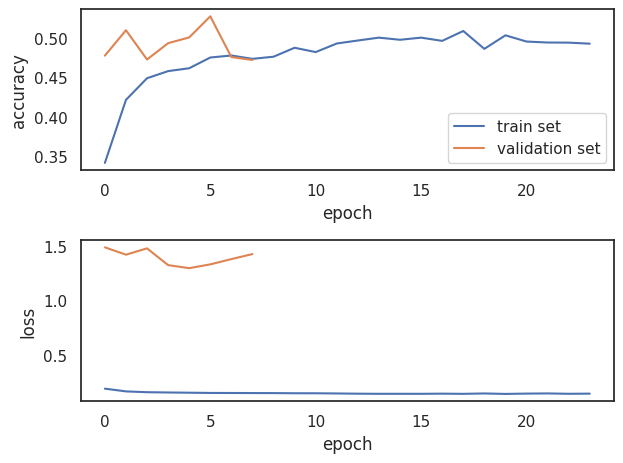

In [10]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['accuracy'],label='train set')
ax[0].plot(history.history['val_accuracy'],label='validation set')
ax[0].set(xlabel='epoch',
          ylabel='accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'],label='train')
ax[1].plot(history.history['val_loss'],label='val')
ax[1].set(xlabel='epoch',
          ylabel='loss')
# ax[1].legend()
fig.tight_layout()

In [11]:
y_pred_test = model.predict(dataset_test)
max_indices = np.argmax(y_pred_test, axis=1)
y_pred_test_ohe = np.zeros_like(y_pred_test)
y_pred_test_ohe[np.arange(y_pred_test.shape[0]), max_indices] = 1.0

59/59 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step


In [12]:
y_true_test = []
for _, lbl in dataset_test:
    y_true_test.extend(lbl.numpy())
y_true_test = np.array(y_true_test)
print(y_true_test.shape)

(1886, 8)


2024-05-23 06:47:17.260116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'antelope_duiker'),
  Text(1, 0, 'bird'),
  Text(2, 0, 'blank'),
  Text(3, 0, 'civet_genet'),
  Text(4, 0, 'hog'),
  Text(5, 0, 'leopard'),
  Text(6, 0, 'monkey_prosimian'),
  Text(7, 0, 'rodent')])

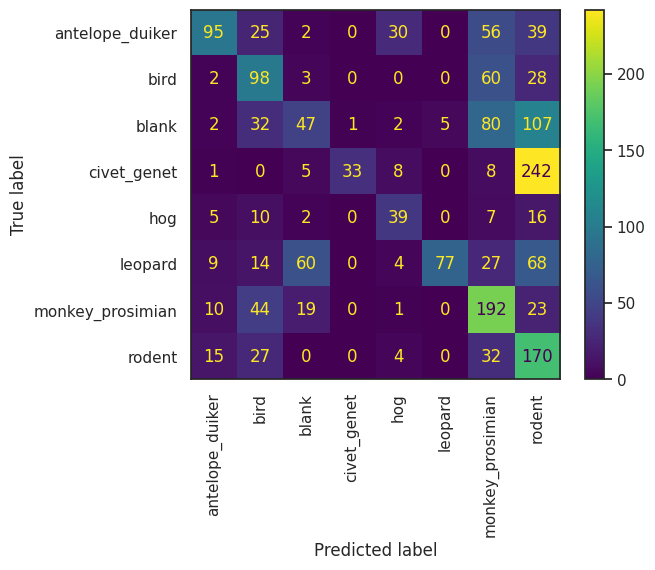

In [13]:
cm = confusion_matrix(np.argmax(y_true_test, axis=1), np.argmax(y_pred_test_ohe, axis=1))

ConfusionMatrixDisplay.from_predictions(np.argmax(y_true_test, axis=1), np.argmax(y_pred_test_ohe, axis=1), display_labels=dataset_test.class_names)
plt.xticks(rotation=90)

In [14]:
model.evaluate(dataset_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.3407 - loss: 1.4724


[1.5670095682144165, 0.3981972336769104]

In [15]:
model.save("../models/ConvNeXtXLarge_v1.keras")